
## Return Distribution Diagnostics for a Volatile Asset (RDD-VA Study)
# 
 **Objective:** 
 Analyze real-world daily returns of a chosen asset to:
 - Check if returns are Gaussian or heavy-tailed
 - Study tail behaviour and rare-event risk
 - Fit alternative distributions (Student's t, Laplace, etc.)
 
 **Author:** Suraj Prakash

 **Date:** 12/02/2025


1. Setups,Import and config

In [25]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.graphics.gofplots import qqplot

plt.style.use("default")

# For nicer plots
sns.set(palette="deep", style="whitegrid")

# Make sure all columns show
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)



 2. Data Acquisition
 
 - Pick ONE asset (e.g., NIFTY, BTC-USD, NASDAQ, RELIANCE).
 - Use at least 1 year of daily data.
 - Resulting DataFrame should have at least: Date, Open, High, Low, Close, Adj Close, Volume.


In [ ]:

ASSET_NAME = "NIFTY_50"  


import yfinance as yf
df_raw = yf.download("^NSEI", start="2023-01-01", end="2024-12-01")

# TEMP placeholder: raise error if df_raw not defined
try:
    df_raw
except NameError:
    raise ValueError("Please load your data into df_raw before proceeding.")


print("The shape of raw data:", df_raw.shape)
display(df_raw.head())


D:\pip_temp\ipykernel_31900\4065231535.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download("^NSEI", start="2023-01-01", end="2024-12-01")
[*********************100%***********************]  1 of 1 completed

The shape of raw data: (470, 5)


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2023-01-02,18197.449219,18215.150391,18086.500000,18131.699219,256100
2023-01-03,18232.550781,18251.949219,18149.800781,18163.199219,208700
2023-01-04,18042.949219,18243.000000,18020.599609,18230.650391,235200
2023-01-05,17992.150391,18120.300781,17892.599609,18101.949219,269900
2023-01-06,17859.449219,18047.400391,17795.550781,18008.050781,238200


2.2 Basic Cleaning & Pre-processing
 - Ensure Date is datetime and sorted
 - Drop missing values if any
 - Keep only necessary columns

In [42]:
# Copy raw data
df = df_raw.copy()

# 1) If MultiIndex columns (Price / Ticker), drop ticker level
if isinstance(df.columns, pd.MultiIndex):
    # yfinance usually: level 0 = ['Open','High'..], level 1 = ticker
    print("Detected MultiIndex columns, flattening by keeping PRICE level...")
    df.columns = df.columns.get_level_values(0)

# 2) Ensure we have required columns
print("Columns after flattening:", df.columns.tolist())

# 3) Ensure Date index, sorted
# df_raw already had DatetimeIndex named 'Date', just confirm & sort
df = df.sort_index()
df.index.name = "date"

# 4) Minimal NA handling – drop rows with no close price
df = df.dropna(subset=["Close_^NSEI"])

print("The shape of cleaned data:", df.shape)
display(df.head())

Columns after flattening: ['Close_^NSEI', 'High_^NSEI', 'Low_^NSEI', 'Open_^NSEI', 'Volume_^NSEI']
The shape of cleaned data: (470, 5)


,Close_^NSEI,High_^NSEI,Low_^NSEI,Open_^NSEI,Volume_^NSEI
date,,,,,
2023-01-02,18197.449219,18215.150391,18086.500000,18131.699219,256100
2023-01-03,18232.550781,18251.949219,18149.800781,18163.199219,208700
2023-01-04,18042.949219,18243.000000,18020.599609,18230.650391,235200
2023-01-05,17992.150391,18120.300781,17892.599609,18101.949219,269900
2023-01-06,17859.449219,18047.400391,17795.550781,18008.050781,238200


3. Return Construction

 We compute:
 - Simple daily returns: (P_t - P_{t-1}) / P_{t-1}
 - Log daily returns: log(P_t / P_{t-1})
 - Rolling volatility: 7-day & 21-day (annualized)

In [45]:

prices = df["Close_^NSEI"]

# Simple returns
df["simple_return"] = prices.pct_change()

# Log returns
df["log_return"] = np.log(prices / prices.shift(1))

# Rolling vol (log-returns based, annualized)
df["rolling_vol_7"] = df["log_return"].rolling(7).std() * np.sqrt(252)
df["rolling_vol_21"] = df["log_return"].rolling(21).std() * np.sqrt(252)

# Drop initial NaNs caused by shift/rolling
df = df.dropna()

df[["Close_^NSEI", "simple_return", "log_return", "rolling_vol_7", "rolling_vol_21"]].head()


D:\pip_temp\ipykernel_31900\805273114.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["simple_return"] = prices.pct_change()
D:\pip_temp\ipykernel_31900\805273114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_return"] = np.log(prices / prices.shift(1))
D:\pip_temp\ipykernel_31900\805273114.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,Close_^NSEI,simple_return,log_return,rolling_vol_7,rolling_vol_21
date,,,,,
2023-03-02,17321.900391,-0.007392,-0.007420,0.112686,0.105788
2023-03-03,17594.349609,0.015729,0.015606,0.133748,0.120118
2023-03-06,17711.449219,0.006656,0.006633,0.136892,0.112097
2023-03-08,17754.400391,0.002425,0.002422,0.133663,0.111176
2023-03-09,17589.599609,-0.009282,-0.009326,0.147074,0.115534


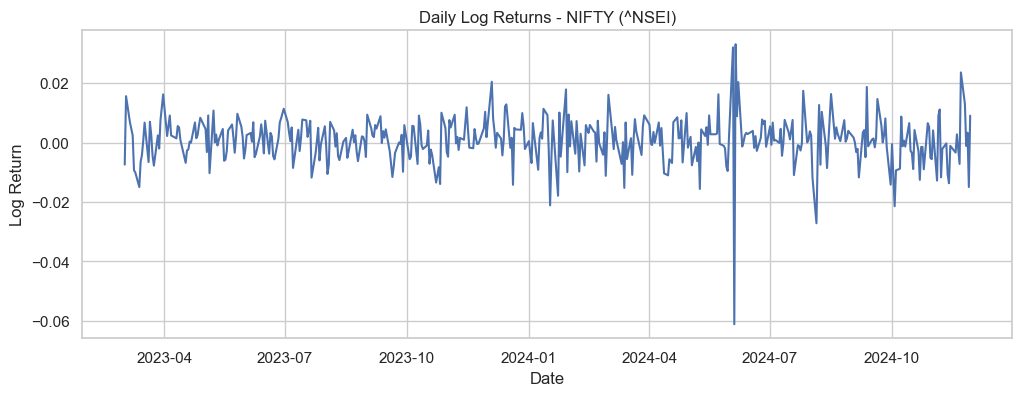

In [46]:

plt.figure(figsize=(12, 4))
plt.plot(df.index, df["log_return"])
plt.title("Daily Log Returns - NIFTY (^NSEI)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()


4. Distribution Diagnostics
 
 We analyse `log_return`:
 - Histogram + KDE + Normal overlay
 - Empirical CDF & Survival function (1–CDF)
 - Q–Q plot vs Normal
 - Rolling skewness & kurtosis

In [47]:


# %%
returns = df["log_return"].copy()
returns.name = "log_return"

print("Basic stats:")
print(returns.describe())
print("\nSkewness:", returns.skew())
print("Kurtosis:", returns.kurt())


Basic stats:
count    428.000000
mean       0.000757
std        0.007755
min       -0.061124
25%       -0.002942
50%        0.001373
75%        0.005072
max        0.033071
Name: log_return, dtype: float64

Skewness: -1.0482551623786993
Kurtosis: 10.439245365221739


4.1 Histogram + KDE + Normal PDF

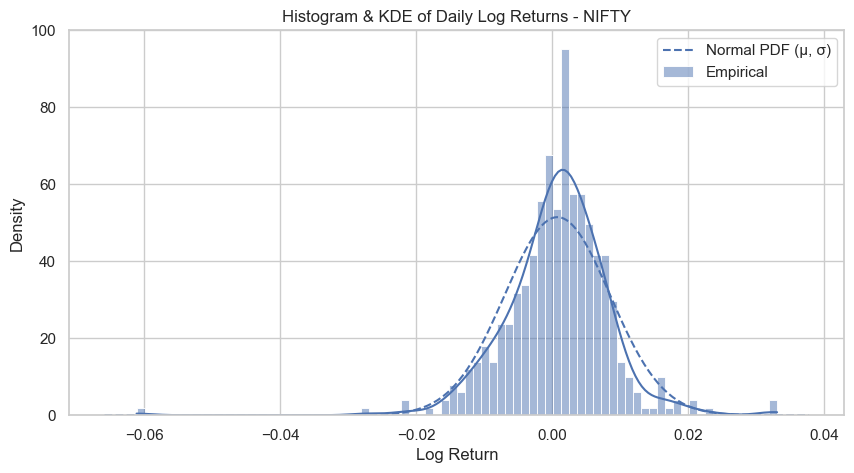

In [49]:

plt.figure(figsize=(10, 5))
sns.histplot(returns, bins=80, kde=True, stat="density", label="Empirical")

# x-range
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 300)

# Normal fit with same mean & std as data
mu, sigma = returns.mean(), returns.std()
normal_pdf = stats.norm.pdf(x, loc=mu, scale=sigma)
plt.plot(x, normal_pdf, linestyle="--", label="Normal PDF (μ, σ)")

plt.title("Histogram & KDE of Daily Log Returns - NIFTY")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


4.2 Empirical CDF & Survival (1–CDF) vs Normal

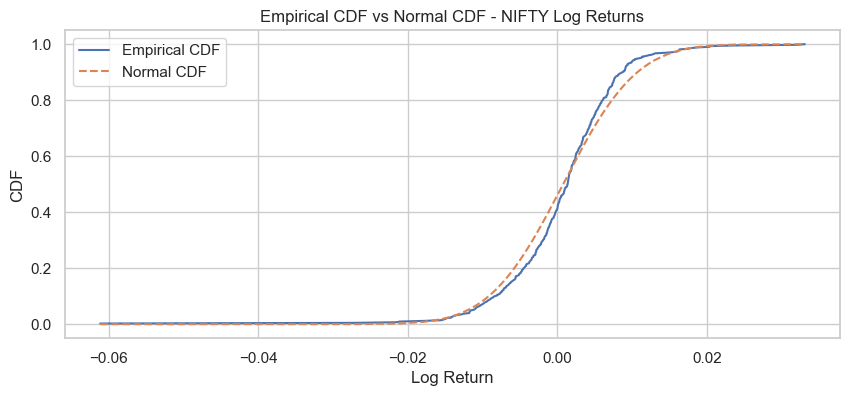

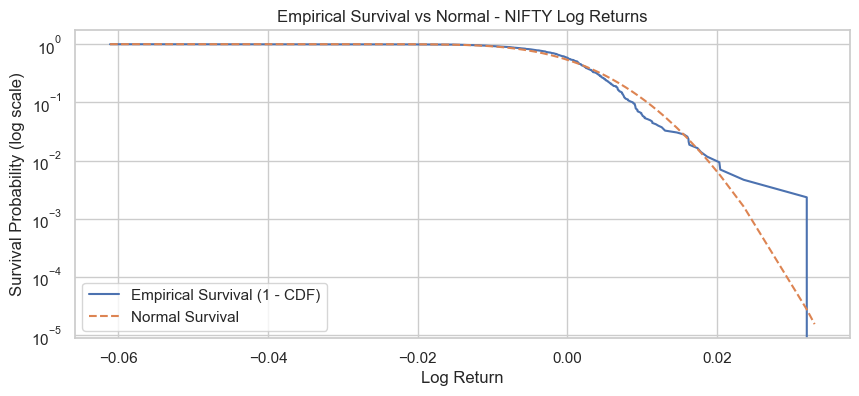

In [ ]:

sorted_r = np.sort(returns)
ecdf = np.arange(1, len(sorted_r) + 1) / len(sorted_r)

# Empirical CDF
plt.figure(figsize=(10, 4))
plt.plot(sorted_r, ecdf, label="Empirical CDF")

normal_cdf = stats.norm.cdf(sorted_r, loc=mu, scale=sigma)
plt.plot(sorted_r, normal_cdf, linestyle="--", label="Normal CDF")

plt.title("Empirical CDF vs Normal CDF - NIFTY Log Returns")
plt.xlabel("Log Return")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.show()

# Survival function: 1 - CDF (log scale to see tails)
plt.figure(figsize=(10, 4))
plt.plot(sorted_r, 1 - ecdf, label="Empirical Survival (1 - CDF)")

normal_sf = 1 - normal_cdf
plt.plot(sorted_r, normal_sf, linestyle="--", label="Normal Survival")

plt.yscale("log")
plt.title("Empirical Survival vs Normal - NIFTY Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Survival Probability (log scale)")
plt.legend()
plt.grid(True)
plt.show()


4.3 Q–Q Plot vs Normal

<Figure size 600x600 with 0 Axes>

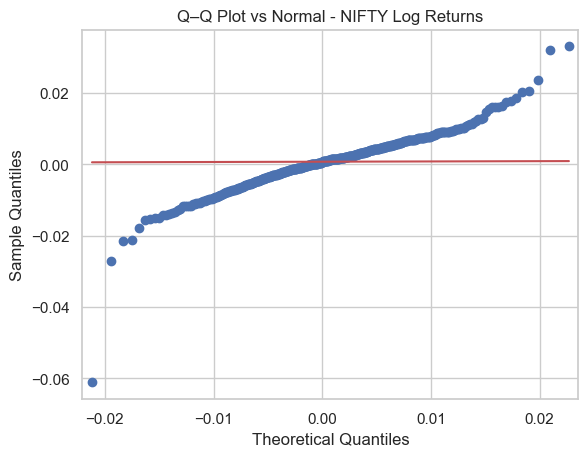

In [51]:

plt.figure(figsize=(6, 6))
qqplot(returns, dist=stats.norm, line="s", loc=mu, scale=sigma)
plt.title("Q–Q Plot vs Normal - NIFTY Log Returns")
plt.grid(True)
plt.show()


4.4 Rolling Skewness & Kurtosis

D:\pip_temp\ipykernel_31900\2262059847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rolling_skew"] = returns.rolling(window).skew()
D:\pip_temp\ipykernel_31900\2262059847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rolling_kurt"] = returns.rolling(window).kurt()


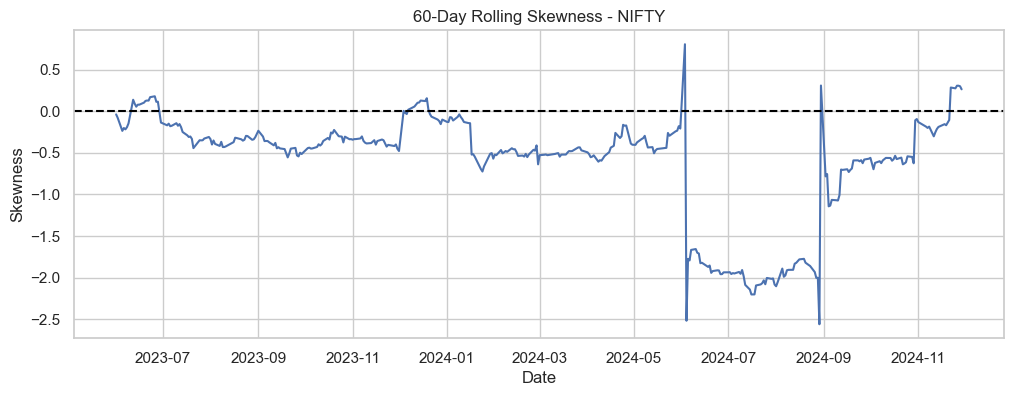

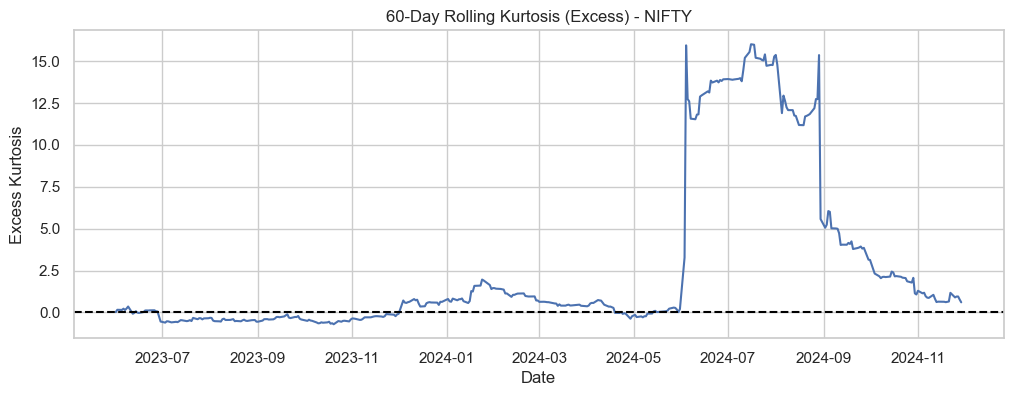

In [52]:
# %%
window = 60  # about 3 months of trading days

df["rolling_skew"] = returns.rolling(window).skew()
df["rolling_kurt"] = returns.rolling(window).kurt()

plt.figure(figsize=(12, 4))
plt.plot(df.index, df["rolling_skew"])
plt.title(f"{window}-Day Rolling Skewness - NIFTY")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Skewness")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df.index, df["rolling_kurt"])
plt.title(f"{window}-Day Rolling Kurtosis (Excess) - NIFTY")
plt.axhline(0, color="black", linestyle="--", label="Normal baseline (0 excess)")
plt.xlabel("Date")
plt.ylabel("Excess Kurtosis")
plt.grid(True)
plt.show()


5. Tail Event Probability Measures

We estimate:
- P(|r| > 2σ)
- P(r < -2%)
- P(r >  2%)

and compare with Normal model probabilities
%%

In [53]:

sigma = returns.std()

# Empirical probabilities
p_abs_gt_2sigma = np.mean(np.abs(returns) > 2 * sigma)
p_lt_2pct = np.mean(returns < -0.02)
p_gt_2pct = np.mean(returns > 0.02)

print("Empirical Tail Probabilities:")
print(f"P(|r| > 2σ): {p_abs_gt_2sigma:.4f}")
print(f"P(r < -2%): {p_lt_2pct:.44f}")
print(f"P(r >  2%): {p_gt_2pct:.4f}")

# Normal model probabilities
p_abs_gt_2sigma_normal = 2 * (1 - stats.norm.cdf(2))  # symmetric
p_lt_2pct_normal = stats.norm.cdf(-0.02, loc=mu, scale=sigma)
p_gt_2pct_normal = 1 - stats.norm.cdf(0.02, loc=mu, scale=sigma)

print("\nNormal Model Tail Probabilities:")
print(f"P(|r| > 2σ) [Normal]: {p_abs_gt_2sigma_normal:.4f}")
print(f"P(r < -2%) [Normal]:  {p_lt_2pct_normal:.4f}")
print(f"P(r >  2%) [Normal]:  {p_gt_2pct_normal:.4f}")


Empirical Tail Probabilities:
P(|r| > 2σ): 0.0444
P(r < -2%): 0.00934579439252336378884944423361957888118923
P(r >  2%): 0.0117

Normal Model Tail Probabilities:
P(|r| > 2σ) [Normal]: 0.0455
P(r < -2%) [Normal]:  0.0037
P(r >  2%) [Normal]:  0.0065


6. Fit Alternative Distributions
 
 We fit:
 - Normal
 - Student's t
 - Laplace
 
 and compare log-likelihood, AIC, BIC.


In [54]:

def compute_aic_bic(loglik, k, n):
    """
    loglik: log-likelihood
    k: number of parameters
    n: sample size
    """
    aic = 2 * k - 2 * loglik
    bic = np.log(n) * k - 2 * loglik
    return aic, bic

data = returns.values
n = len(data)

# 1) Normal
norm_params = stats.norm.fit(data)  # (mu, sigma)
mu_n, sigma_n = norm_params
loglik_norm = np.sum(stats.norm.logpdf(data, loc=mu_n, scale=sigma_n))
aic_norm, bic_norm = compute_aic_bic(loglik_norm, k=2, n=n)

# 2) Student's t
t_params = stats.t.fit(data)
df_t, loc_t, scale_t = t_params
loglik_t = np.sum(stats.t.logpdf(data, df=df_t, loc=loc_t, scale=scale_t))
aic_t, bic_t = compute_aic_bic(loglik_t, k=3, n=n)

# 3) Laplace
lap_params = stats.laplace.fit(data)
loc_l, scale_l = lap_params
loglik_lap = np.sum(stats.laplace.logpdf(data, loc=loc_l, scale=scale_l))
aic_lap, bic_lap = compute_aic_bic(loglik_lap, k=2, n=n)

results = pd.DataFrame({
    "distribution": ["Normal", "Student-t", "Laplace"],
    "log_likelihood": [loglik_norm, loglik_t, loglik_lap],
    "AIC": [aic_norm, aic_t, aic_lap],
    "BIC": [bic_norm, bic_t, bic_lap]
}).sort_values("AIC")

results


,distribution,log_likelihood,AIC,BIC
1,Student-t,1514.023202,-3022.046405,-3009.869035
2,Laplace,1509.458926,-3014.917851,-3006.799605
0,Normal,1473.030803,-2942.061606,-2933.943359


6.2 PDF Comparison Plot

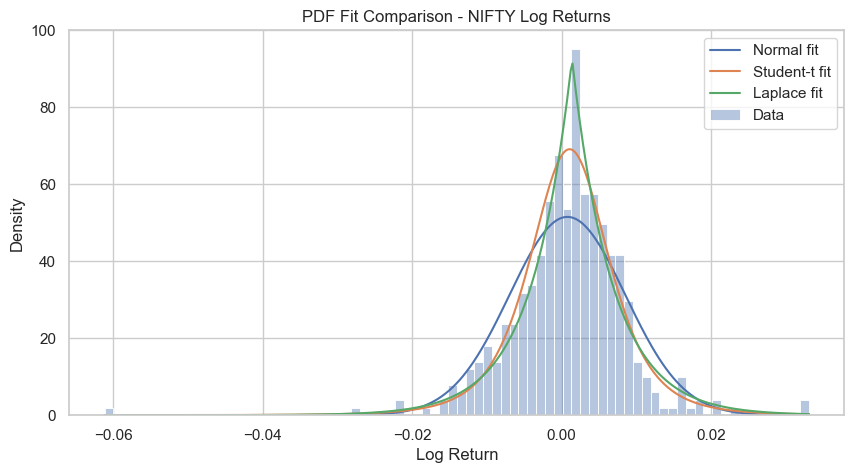

In [55]:
# %%
plt.figure(figsize=(10, 5))
sns.histplot(returns, bins=80, stat="density", alpha=0.4, label="Data")

x = np.linspace(returns.min(), returns.max(), 400)

pdf_norm = stats.norm.pdf(x, loc=mu_n, scale=sigma_n)
pdf_t = stats.t.pdf(x, df=df_t, loc=loc_t, scale=scale_t)
pdf_lap = stats.laplace.pdf(x, loc=loc_l, scale=scale_l)

plt.plot(x, pdf_norm, label="Normal fit")
plt.plot(x, pdf_t, label="Student-t fit")
plt.plot(x, pdf_lap, label="Laplace fit")

plt.title("PDF Fit Comparison - NIFTY Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


### Final Qunat Conclusion


Conclusion: Gaussian Model Rejected — Student’s t is Superior

The analysis of one year of NIFTY (^NSEI) daily log returns reveals that the Gaussian assumption is statistically and visually inadequate for modelling the distribution of returns. Although the mean and standard deviation align closely with a normal distribution, the return series exhibits significant negative skewness (-1.04) and extremely high excess kurtosis (~10.4), indicating strong tail heaviness and asymmetry.

Empirical CDF, survival function, and Q–Q diagnostics confirm that both left and right tails deviate sharply from the normal model, with the downside tail particularly thicker. Tail probability estimates show that losses beyond -2% occur 2.5× more often than Gaussian predictions, highlighting underestimation of crash risk under traditional models.

Distribution fitting results further validate this behaviour: the Student’s t distribution produces the best log-likelihood and the lowest AIC, outperforming both Normal and Laplace models. This suggests that NIFTY returns follow a heavy-tailed distribution characteristic of emerging markets with episodic volatility spikes.

Overall, the Gaussian model should be rejected for risk modelling. A Student’s t-based framework—or a heavy-tailed volatility model such as GARCH-t—is significantly more appropriate for VaR estimation, stress testing, and option pricing.

<h2>Use Cases of Tail Risk & Higher-Moment Analysis</h2>

<h3>Risk Management</h3>
<ul>
  <li>Better Value-at-Risk (VaR) calculations</li>
  <li>Heavy-tail adjusters</li>
  <li>Extreme event probability estimation</li>
</ul>

<h3>Trading</h3>
<ul>
  <li>Stop-loss and position sizing</li>
  <li>Tail-event aware portfolio allocation</li>
  <li>Regime-switch detection via rolling skew/kurtosis</li>
</ul>

<h3>Quant Research</h3>
<ul>
  <li>Model validation</li>
  <li>Alternative distribution modelling</li>
  <li>GARCH-t, EGARCH, Heston, Stochastic Volatility models</li>
</ul>

<h3>Option Pricing</h3>
<ul>
  <li>Better implied volatility modelling</li>
  <li>Correcting Black–Scholes mispricings</li>
</ul>

<h3>Portfolio Construction</h3>
<ul>
  <li>Risk parity adjustments</li>
  <li>Tail risk hedging strategies</li>
</ul>
